In [4]:
import csv
import cv2
import argparse
import os
import io
import glob
import h5py
import shutil
import numpy as np
import pandas as pd
import pickle as pkl
import os.path as op

from bvh_converter.bvhplayer_skeleton import *
from pathlib2 import Path
from mlib import mio
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def extend_names_xyz(names):
    if type(names) != list:
        names = [str(names)]
    col_names = []
    _ = [col_names.extend((k+'.X', k+'.Y', k+'.Z')) for k in names]
    return col_names

def filter_columns(file_in, file_out=None, norm='ori', ret=False):
    assert norm in ['ori', 'norm', 'both']
    parts_names = ['頭', '腕.R', '腕.L', 'ひじ.R', 'ひじ.L', '足.R', '足.L', '手首.R', '手首.L',  'ひざ.R', 'ひざ.L', '足ＩＫ.R', '足ＩＫ.L']
    # parts_names = ['頭', '腕.R', '腕.L', 'ひじ.R', 'ひじ.L', '足.R', '足.L', '手首.R', '手首.L',  'ひざ.R', 'ひざ.L', '足ＩＫ.R', '足ＩＫ.L']
    
    col_names = extend_names_xyz(parts_names)
    # Blender will add 5 extra frames to a vmd 
    # motion compared to original MMD motion.
    raw = pd.read_csv(file_in, encoding='gbk')[5:]
    selected_joints = raw[col_names]

    joint_list = []
    
    for part in parts_names:
        joint = selected_joints[[part+'.X', part+'.Y', part+'.Z']].to_numpy()
        joint_list.append(joint)

    joint_arr = np.array(joint_list)
    del joint_list

    if norm != 'ori':
        xy_norm_factor = joint_arr[:,:,:2].mean(axis=0)
        z_norm_factor = joint_arr[-2:,:,-1:].min(axis=0)
        norm_factor = np.concatenate((xy_norm_factor,z_norm_factor), axis=1)
        # print(norm_factor.shape)
        
        joint_arr_normed = joint_arr - norm_factor
        joint_arr_normed = joint_arr_normed.transpose(1,0,2)

    joint_arr = joint_arr.transpose(1,0,2)

    if file_out is None:
        if norm != 'norm':
            file_out = op.splitext(file_in)[0]+'_kp13.pkl'
            with open(file_out, 'wb') as f:
                pkl.dump(joint_arr, f)

        if norm != 'ori':
            file_out = op.splitext(file_in)[0]+'_kp13_normed.pkl'
            with open(file_out, 'wb') as f:
                pkl.dump(joint_arr_normed, f)

    if ret:
        if norm == 'ori':
            return joint_arr
        elif norm == 'norm':
            return joint_arr_normed
        else:
            return joint_arr, joint_arr_normed

In [4]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_skeleton_lines(x, y, z):
    """
    From DHP19 toolbox
    """
    # rename joints to identify name and axis
    x_head, x_shoulderR, x_shoulderL, x_elbowR = x[0], x[1], x[2], x[3]
    x_elbowL, x_hipR, x_hipL = (
        x[4],
        x[5],
        x[6],
    )
    x_handR, x_handL, x_kneeR = (
        x[7],
        x[8],
        x[9],
    )
    x_kneeL, x_footR, x_footL = x[10], x[11], x[12]

    y_head, y_shoulderR, y_shoulderL, y_elbowR = y[0], y[1], y[2], y[3]
    y_elbowL, y_hipR, y_hipL = (
        y[4],
        y[5],
        y[6],
    )
    y_handR, y_handL, y_kneeR = (
        y[7],
        y[8],
        y[9],
    )
    y_kneeL, y_footR, y_footL = y[10], y[11], y[12]

    z_head, z_shoulderR, z_shoulderL, z_elbowR = z[0], z[1], z[2], z[3]
    z_elbowL, z_hipR, z_hipL = (
        z[4],
        z[5],
        z[6],
    )
    z_handR, z_handL, z_kneeR = (
        z[7],
        z[8],
        z[9],
    )
    z_kneeL, z_footR, z_footL = z[10], z[11], z[12]

    # definition of the lines of the skeleton graph
    skeleton = np.zeros((14, 3, 2))
    skeleton[0, :, :] = [
        [x_head, x_shoulderR],
        [y_head, y_shoulderR],
        [z_head, z_shoulderR],
    ]
    skeleton[1, :, :] = [
        [x_head, x_shoulderL],
        [y_head, y_shoulderL],
        [z_head, z_shoulderL],
    ]
    skeleton[2, :, :] = [
        [x_elbowR, x_shoulderR],
        [y_elbowR, y_shoulderR],
        [z_elbowR, z_shoulderR],
    ]
    skeleton[3, :, :] = [
        [x_elbowL, x_shoulderL],
        [y_elbowL, y_shoulderL],
        [z_elbowL, z_shoulderL],
    ]
    skeleton[4, :, :] = [
        [x_elbowR, x_handR],
        [y_elbowR, y_handR],
        [z_elbowR, z_handR],
    ]
    skeleton[5, :, :] = [
        [x_elbowL, x_handL],
        [y_elbowL, y_handL],
        [z_elbowL, z_handL],
    ]
    skeleton[6, :, :] = [
        [x_hipR, x_shoulderR],
        [y_hipR, y_shoulderR],
        [z_hipR, z_shoulderR],
    ]
    skeleton[7, :, :] = [
        [x_hipL, x_shoulderL],
        [y_hipL, y_shoulderL],
        [z_hipL, z_shoulderL],
    ]
    skeleton[8, :, :] = [[x_hipR, x_kneeR], [y_hipR, y_kneeR], [z_hipR, z_kneeR]]
    skeleton[9, :, :] = [[x_hipL, x_kneeL], [y_hipL, y_kneeL], [z_hipL, z_kneeL]]
    skeleton[10, :, :] = [
        [x_footR, x_kneeR],
        [y_footR, y_kneeR],
        [z_footR, z_kneeR],
    ]
    skeleton[11, :, :] = [
        [x_footL, x_kneeL],
        [y_footL, y_kneeL],
        [z_footL, z_kneeL],
    ]
    skeleton[12, :, :] = [
        [x_shoulderR, x_shoulderL],
        [y_shoulderR, y_shoulderL],
        [z_shoulderR, z_shoulderL],
    ]
    skeleton[13, :, :] = [[x_hipR, x_hipL], [y_hipR, y_hipL], [z_hipR, z_hipL]]
    return skeleton

def get_3d_ax(ret_fig=False):
    fig = plt.figure(figsize=(8, 8))
    # ax = Axes3D(fig)
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    # Bonus: To get rid of the grid as well:
    ax.grid(False)
    ax.view_init(30, 240)
    if not ret_fig:
        return ax
    else:
        return ax, fig

def plot_3d(points, ax, c="red", limits=None, plot_lines=True, angle=270, cam_height=10):
    """
    Plot the provided skeletons in 3D coordinate space
    Args:
        ax: axis for plot
        y_true_pred: joints to plot in 3D coordinate space
        c: color (Default value = 'red')
        limits: list of 3 ranges (x, y, and z limits)
        plot_lines:  (Default value = True)

    Note:
        Plot the provided skeletons. Visualization purpose only

    From DHP19 toolbox
    """

    if limits is None:
        limits = [[-3, 3], [-3, 3], [0, 15]]

    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]

    ax.scatter(x, y, z, zdir="z", s=20, c=c, marker="o", depthshade=True)

    lines_skeleton = get_skeleton_lines(x, y, z)

    if plot_lines:
        for line in range(len(lines_skeleton)):
            ax.plot(
                lines_skeleton[line, 0, :],
                lines_skeleton[line, 1, :],
                lines_skeleton[line, 2, :],
                c,
                label="gt",
            )

    ax.set_xlabel("X Label")
    ax.set_ylabel("Y Label")
    ax.set_zlabel("Z Label")
    x_limits = limits[0]
    y_limits = limits[1]
    z_limits = limits[2]
    x_range = np.abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = np.abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = np.abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)
    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5 * np.max([x_range, y_range, z_range])
    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

    ax.view_init(elev=cam_height, azim=angle)

def plot_skeleton_3d(points, angle=270, cam_height=10, ret_fig=False):
    """
        Args:
           M: extrinsic matrix as tensor of shape 4x3
           xyz: torch tensor of shape NUM_JOINTSx3
           pred: torch tensor of shape NUM_JOINTSx3
        """
    ax, fig = get_3d_ax(ret_fig=True)
    plot_3d(points, ax, c='red', angle=angle, cam_height=cam_height)
    if ret_fig:
        return fig

In [347]:
joint_arr_normed = filter_columns(csv_file, norm='norm', ret=True)

In [422]:
plot_skeleton_3d(joint_arr_normed[0], 270)
plt.show()

## Blender APIs

In [ ]:
# This and the following cells are for blender plugin
# They can not work here.

import byp
C = bpy.context
D = bpy.data

# Set Frame
bpy.context.scene.frame_set('Frame Num')

# Frame Start Index
C.scene.frame_start
C.scene.frame_end

In [ ]:
import os.path as op
import numpy as np
import pickle as pkl

###################################################################
############### PARAMETERS YOU NEED TO FILL IN ####################
model_name='Tda Hood Miku 1.00 by iRon0129'
output_dir = r'D:\MMD\Setting_Pairs\miku_neutral_street_bluestar'
output_flags = {'raw': True, 'kp13': False, 'kp13_normed': True}
###################################################################

# Get part of the data using bone names
def pose_slice(names, data):
    if type(names) not in (list, tuple):
        names = [str(names)]
    indexes = np.array([data['names'].index(k) for k in names])
    joint_arr = data['data'][:,indexes]
    return joint_arr

armature_name = model_name + '_arm'
frame_start = C.scene.frame_start
frame_end = C.scene.frame_end

pose_bones = {pb.name: pb for pb in D.objects[armature_name].pose.bones}
pb_names = list(pose_bones.keys())

data = np.zeros((frame_end-frame_start+1, len(pb_names), 3))
for frame_idx in range(frame_start, frame_end+1):
    bpy.context.scene.frame_set(frame_idx)
    for bone_idx, pbn in enumerate(pb_names):
        data[frame_idx-1, bone_idx, :] = pose_bones[pbn].head

data_dict = {'names': pb_names, 'data': data}

In [412]:
parts_names_kp13 = ['頭', '腕.R', '腕.L', 'ひじ.R', 'ひじ.L', '足.R', '足.L', 
        '手首.R', '手首.L',  'ひざ.R', 'ひざ.L', '足首.R', '足首.L']
kp13_arr = pose_slice(parts_names_kp13, data_dict)

# Use the center point 'グルーブ' as the center x and y coordinate
center_arr = pose_slice('グルーブ', data_dict)
center_arr[:,:,2] = 0
kp13_arr_normed = kp13_arr - center_arr

# Output files according to the flag setting
if output_flags['raw']:
    with open(op.join(output_dir, 'motion_dict.pkl'), 'wb') as f:
        pkl.dump(data_dict, f)

if output_flags['kp13']:
    data_dict_kp13 = {'names': parts_names_kp13, 'data': kp13_arr}
    with open(op.join(output_dir, 'motion_dict_kp13.pkl'), 'wb') as f:
        pkl.dump(data_dict_kp13, f)

if output_flags['kp13_normed']:
    data_dict_kp13_normed = {'names': parts_names_kp13, 'data': kp13_arr_normed}
    with open(op.join(output_dir, 'motion_dict_kp13_normed.pkl'), 'wb') as f:
        pkl.dump(data_dict_kp13_normed, f)

# Generate Videos from Blender-Dumped Poses

In [12]:
## This cell is not going to be used in blender plugin
output_path = r'D:\MMD\Setting_Pairs\miku_neutral_street_bluestar\motion_dict_kp13_normed.pkl'

with open(output_path, 'rb') as f:
    data_dict = pkl.load(f)

kp13_arr_centered = data_dict['data']

In [13]:
lowest_foot = kp13_arr_centered[:,-2:,-1:].min(axis=1)
kp13_arr_centered_xyz = kp13_arr_centered
kp13_arr_centered_xyz[:,:,-1] -= lowest_foot
highest_head = kp13_arr_centered_xyz[:,0,-1].max()
kp13_arr_normed_xyz = kp13_arr_centered_xyz/highest_head

15.874866008758545


In [508]:
# kp13_arr_normed = kp13_arr_normed[:6830]
print(kp13_arr_normed.shape)

(6831, 13, 3)


In [491]:
def plt2arr(fig, draw=True):
    """
    need to draw if figure is not drawn yet
    """
    if draw:
        fig.canvas.draw()
    rgba_buf = fig.canvas.buffer_rgba()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.frombuffer(rgba_buf, dtype=np.uint8).reshape((h,w,4))[:,:,:3]
    return rgba_arr

def skeleton_frame(i, view_angle=240):
    fig = plot_skeleton_3d(kp13_arr_normed[i], view_angle, ret_fig=True)
    data = plt2arr(fig, True)
    plt.cla()
    return data

# data = skeleton_frame(10)

In [502]:
import numpy as np
import cv2

data = skeleton_frame(0)
size = data.shape[:2]
frame_num = kp13_arr_normed.shape[0]
frame_step = 1
fps = 30
out = cv2.VideoWriter('./results/output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]))
for i in range(0, frame_num, frame_step):
    data = skeleton_frame(i)
    data = cv2.cvtColor(data, cv2.COLOR_RGB2BGR)
    # data = np.random.randint(0, 256, size, dtype='uint8')
    out.write(data)
out.release()

# Generate Image Sequences from poses

In [504]:
frame_num = 10#kp13_arr_normed.shape[0]
frame_step = 1
view_angle = 240
for i in range(0, frame_num, frame_step):
    plot_skeleton_3d(kp13_arr_normed[i], view_angle)
    # plt.show()
    plt.savefig('./results/pose_gt_normed/%5d.png'%i)
    plt.close('all')

In [440]:
import glob
frames = glob.glob('./results/pose_gt_normed*.png')
print(len(frames))

6801


In [445]:
import ffmpeg
(
    ffmpeg
    .input('./results/pose_gt_normed/#####.png', pattern_type='glob', framerate=30)
    .output('./results/pose_gt_normed.mp4')
    .run()
)

In [443]:
# for frame_name in frames:
#     stem = op.splitext(op.split(frame_name)[1])[0].lstrip('pose_gt_normed')
#     digit = int(stem)
#     new_name = op.split(frame_name)[0]+'/pose_gt_normed/'+f"{digit:05d}"+op.splitext(frame_name)[1]
#     os.rename(frame_name, new_name)
    # print(f"{stem}->{new_name}")

# for frame_name in frames:
#     stem = op.splitext(op.split(frame_name)[1])[0]
#     digit = int(stem)
#     new_name = op.split(frame_name)[0]+f"{digit:05d}"+op.splitext(frame_name)[1]
#     os.rename(frame_name, new_name)

# Move Compressed Videos to another folder

In [69]:
def move_comp(raw_root, comp_root, test_only=True):
    raw_videos = glob.glob(op.join(raw_root, '*', '*.mp4'))
    os.makedirs(comp_root, exist_ok=True)
    print('Total Video Num: ', len(raw_videos))

    for raw_path in raw_videos:
        raw_dirname, filename = Path(raw_path).parts[-2:]
        new_dir = op.join(comp_root, raw_dirname)
        new_path = op.join(new_dir, filename.lstrip('[SHANA]'))
        if not op.exists(new_dir):
            os.makedirs(new_dir, exist_ok=True)
        print(raw_path, ' -> ', new_path)
        if not test_only:
            os.rename(raw_path, new_path)

In [61]:
raw_root = r'J:\datasets\DVS\mmd\raw'
comp_root = r'J:\datasets\DVS\mmd\compressed'
move_comp(raw_root, comp_root, test_only=True)
# raw_videos = glob.glob(op.join(raw_root, '*', '*.mp4'))
# os.makedirs(comp_root, exist_ok=True)
# print(len(raw_videos))

24


# Resize the Compressed Videos to Smaller Size

In [19]:
import ffmpeg
resolution = (462, 260)
res_str = f'{resolution[0]}x{resolution[1]}'
print(res_str)

def resize_videos(in_root, out_root, test_only=True):
    raw_videos = glob.glob(op.join(in_root, '*', '*.mp4'))
    os.makedirs(out_root, exist_ok=True)
    print('Total Video Num: ', len(raw_videos))

    for raw_path in raw_videos:
        raw_dirname, filename = Path(raw_path).parts[-2:]
        new_dir = op.join(out_root, raw_dirname)
        new_path = op.join(new_dir, filename)
        if not op.exists(new_dir):
            os.makedirs(new_dir, exist_ok=True)
        print(raw_path, ' -> ', new_path)
        if not test_only:
            ffmpeg.input(raw_path).output(new_path, s=res_str).overwrite_output().run()

462x260


In [20]:
raw_root = r'J:\datasets\DVS\mmd\compressed'
comp_root = r'J:\datasets\DVS\mmd\lr_videos'
resize_videos(raw_root, comp_root, test_only=False)

Total Video Num:  24
J:\datasets\DVS\mmd\compressed\miku_jap_ll\front.mp4  ->  J:\datasets\DVS\mmd\lr_videos\miku_jap_ll\front.mp4


FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: 'J:\\datasets\\DVS\\mmd\\compressed\\miku_jap_ll\\front.mp4' -> 'J:\\datasets\\DVS\\mmd\\lr_videos\\miku_jap_ll\\front.mp4'

# Visualize the events

In [7]:
import numpy as np
import h5py
from collections import Counter
import matplotlib.pyplot as plt

In [12]:
# fname = r"D:\MMD\Projects\low-ligth-multi-motion-test\test8\events.h5" #0.002
# fname = r'D:\MMD\Projects\low-ligth-multi-motion-test\test4\events.h5' # no
fname = r'D:\MMD\Projects\test\test2\events.h5' #0.004
f_in =h5py.File(fname, 'r')
print(f_in.keys(), f_in['events'].shape)

<KeysViewHDF5 ['events']> (3117421, 4)


In [13]:
timestemps = np.sort(list(set(f_in['events'][:,0])))
print(timestemps[:10])
deltas = []
for i in range(timestemps.shape[0]-1):
    deltas.append(timestemps[i+1]-timestemps[i])
# deltas = np.array(list(set(deltas)))
# deltas.sort()
# print(deltas)
ct = Counter(deltas)
# print(ct, '\n', ct.most_common())
print(ct.most_common())

[17499 18333 19166 19999 20833 21666 22499 23333 24166 24999]
[(1111, 887), (1042, 667), (1282, 631), (1389, 575), (1190, 543), (1515, 482), (1191, 442), (1041, 389), (980, 370), (926, 340), (1852, 298), (1667, 271), (981, 242), (833, 182), (1666, 138), (1516, 126), (1112, 103), (1388, 102), (2083, 102), (1283, 99), (834, 94), (877, 92), (1851, 63), (1281, 63), (2084, 55), (2381, 53), (2778, 46), (725, 45), (641, 45), (925, 38), (758, 36), (1043, 32), (1514, 30), (757, 29), (694, 26), (724, 24), (878, 22), (695, 22), (3333, 20), (1390, 19), (2380, 15), (2777, 14), (794, 13), (3334, 10), (2382, 9), (1192, 9), (793, 8), (1853, 8), (642, 4), (4167, 3), (2082, 3), (640, 3), (832, 3), (4166, 1), (759, 1), (1668, 1)]


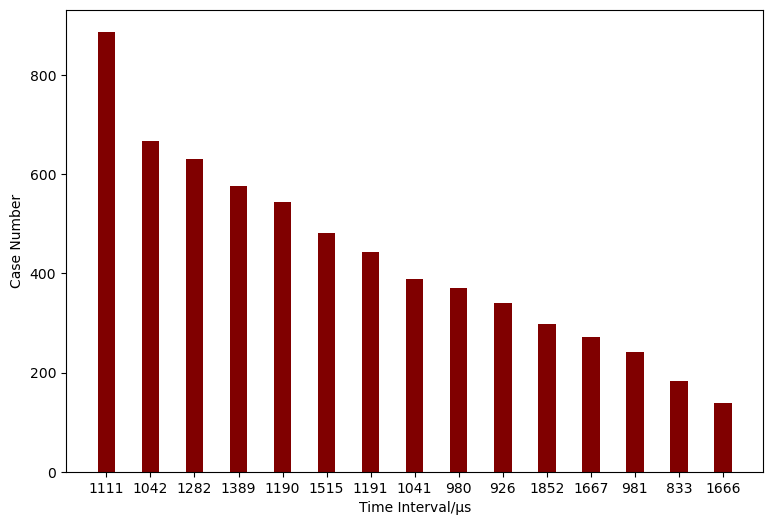

In [14]:
# creating the bar plot
fig = plt.figure(figsize=(9,6))
ct_sort = np.array(ct.most_common(n=len(ct.keys())))[:15]
names = [str(i) for i in ct_sort[:,0]]
values = ct_sort[:,1]
plt.bar(names, values, color ='maroon',
        width = 0.4)
plt.xlabel('Time Interval/μs')
plt.ylabel('Case Number')
plt.show()

[16684 18769 20855 22941 25026 27112 29197 31283 33368 35454]
2085

max(f_in['events'][:,1]) = 345

max(f_in['events'][:,2]) = 259

set(f_in['events'][:,3]) = {0, 1}

f_in['events'].shape = (10942848, 4)

# V2E Parameters

## Necessary Parameters

### Control
- `--overwrite` 
- `--unique_output_folder true`
- `-no_preview`

### Input
- `--input_frame_rate 30` 这个看似可以设定输入视频的FPS，然而实际上如果输入是视频这个不用设置，设置了也没用，会读取视频自己的FPS。当且仅当输入为图片序列时有效。

- `--input_slowmotion_factor 1` 这个参数极具误导性。它不针对slow motion插值做任何工作，而是用于修复输入视频的bug。比如本来拍的时候这个视频是120FPS，但是出于某种原因，实际上显示的播放FPS只有30FPS，那么，这里应该设置为4，用于修复这个问题。如果本来正常的视频设置了这个值为非1，那么如果该factor>1, 那么输出DVS视频则只有原来的时长/factor倍。反之亦然。 

### Output Video
- `--dvs_exposure duration 0.0083333` % 每帧曝光时长。这个只是针对输出视频的，对events本身的timestamps精度没有任何影响。而且影响的是视频中每帧曝光时间长短或曝光events数，但对帧率*没有影响！*

- `--avi_frame_rate 60` % 这里是直观的设置输出DVS视频的FPS，同样，对events的timestamps精度无影响。这个参数要和`--timestamp_resolution` 搭配使用。如果这个FPS设置的太大，而`--timestamp_resolution`不够小，即events的实际分辨率不足，那输出的DVS Video很容易出现跳帧现象，即一帧正常，有很多events，而下一帧就GG了，可能完全没有events，或是很少。建议至少这个`1/timestamp_resolution>avi_frame_rate`。

- 

### Output Other

- `--dvs_h5 events.h5` 输出一个events.h5文件，里面只有一个key，即events。内容就是简单的事件堆叠。


### DVS Params
- `--auto_timestamp_resolution true` 用于自动保证一个像素不会在下一帧移动多个像素，每次只移动一格。
- `--timestamp_resolution 0.001` 可以说这个就是最关键的参数了。用于计算插值把输入视频插成多少倍。这里指定的是两个events之间最多的时间间隔，实际生成的events只会比这个更加短时间。这里的参数设置的是把输入视频插值为1000Hz，之后计算DVS。如果输入FPS为60，插值倍数为17。
- `--cutoff_hz 30` 这个数字越小，输出的events越稀薄，即同一条edge的变化带来的事件会更少。如果这个值设置为<=0，那么忽略低通滤波器直接。如果这个值无限大，依然相当于忽略滤波器。

#### Noisy Condition
- `--pos_thres 0.2 --neg_thres 0.2 --sigma_thres 0.05 --cutoff_hz 30 --leak_rate_hz 0.1 --shot_noise_rate_hz 5`

#### Custom Condition
- `--pos_thres 0.2 --neg_thres 0.2 --sigma_thres 0.05 --cutoff_hz 30 --leak_rate_hz 0.1 --shot_noise_rate_hz 5`

#### Clean Condition
- `--pos_thres 0.2 --neg_thres 0.2 --sigma_thres 0.02 --cutoff_hz 0 --leak_rate_hz 0 --shot_noise_rate_hz 0`



### SloMo Params




- `` -

v2e.py --overwrite --unique_output_folder true --no_preview --input_slowmotion_factor 1 --auto_timestamp_resolution true --pos_thres 0.2 --neg_thres 0.2 --sigma_thres 0.03 --cutoff_hz 30 --leak_rate_hz 0.01 --shot_noise_rate_hz 0.5 --output_height 260 --output_width 462 --dvs_exposure duration 0.0166666667 --timestamp_resolution 0.002 --dvs_h5 events.h5 --dvs_text None --dvs_aedat2 None --avi_frame_rate 60 --slomo_model E:\GitHub\v2e\input\SuperSloMo39.ckpt -i D:\MMD\Projects\low-ligth-multi-motion-test\001.avi --output_folder D:\MMD\Projects\low-ligth-multi-motion-test\test16_mid_noise --batch_size 16 

In [47]:
!cd E:\GitHub\v2e
cmd = r"v2e.py --overwrite --unique_output_folder true --no_preview --input_slowmotion_factor 1 --auto_timestamp_resolution true --pos_thres 0.2 --neg_thres 0.2 --sigma_thres 0.03 --cutoff_hz 30 --leak_rate_hz 0.01 --shot_noise_rate_hz 0.5 --output_height 260 --output_width 462 --dvs_exposure duration 0.0166666667 --timestamp_resolution 0.002 --dvs_h5 events.h5 --dvs_text None --dvs_aedat2 None --avi_frame_rate 60 --slomo_model E:\GitHub\v2e\input\SuperSloMo39.ckpt -i 'D:\MMD\Projects\low-ligth-multi-motion-test\001.avi' --output_folder 'D:\MMD\Projects\low-ligth-multi-motion-test\test16_mid_noise' --batch_size 16 "

os.system('ls')

1

In [43]:
import shlex
import subprocess

cmd_splits = shlex.split('ls -l')

process = subprocess.Popen(cmd_splits) #,
                    #  stdout=subprocess.PIPE, 
                    #  stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
stdout, stderr

FileNotFoundError: [WinError 2] 系统找不到指定的文件。

In [48]:
shlex.split(cmd)

['v2e.py',
 '--overwrite',
 '--unique_output_folder',
 'true',
 '--no_preview',
 '--input_slowmotion_factor',
 '1',
 '--auto_timestamp_resolution',
 'true',
 '--pos_thres',
 '0.2',
 '--neg_thres',
 '0.2',
 '--sigma_thres',
 '0.03',
 '--cutoff_hz',
 '30',
 '--leak_rate_hz',
 '0.01',
 '--shot_noise_rate_hz',
 '0.5',
 '--output_height',
 '260',
 '--output_width',
 '462',
 '--dvs_exposure',
 'duration',
 '0.0166666667',
 '--timestamp_resolution',
 '0.002',
 '--dvs_h5',
 'events.h5',
 '--dvs_text',
 'None',
 '--dvs_aedat2',
 'None',
 '--avi_frame_rate',
 '60',
 '--slomo_model',
 'E:GitHubv2einputSuperSloMo39.ckpt',
 '-i',
 'D:\\MMD\\Projects\\low-ligth-multi-motion-test\\001.avi',
 '--output_folder',
 'D:\\MMD\\Projects\\low-ligth-multi-motion-test\\test16_mid_noise',
 '--batch_size',
 '16']

In [51]:
CMD = r"""python v2e.py --overwrite --unique_output_folder true --no_preview 
--input_slowmotion_factor 1 --auto_timestamp_resolution true 
--pos_thres 0.2 --neg_thres 0.2 --sigma_thres 0.03 --cutoff_hz 30 
--leak_rate_hz 0.01 --shot_noise_rate_hz 0.5 --output_height 260 
--output_width 462 --dvs_exposure duration 0.0166666667 
--timestamp_resolution 0.002 --dvs_h5 events.h5 --dvs_text None 
--dvs_aedat2 None --avi_frame_rate 60 --slomo_model "E:\GitHub\v2e\input\SuperSloMo39.ckpt" 
-i "D:\MMD\Projects\low-ligth-multi-motion-test\001.avi" --output_folder 
"D:\MMD\Projects\low-ligth-multi-motion-test\test17_mid_noise"
--batch_size 16"""

In [53]:
print(CMD.replace('\n',''))

python v2e.py --overwrite --unique_output_folder true --no_preview --input_slowmotion_factor 1 --auto_timestamp_resolution true --pos_thres 0.2 --neg_thres 0.2 --sigma_thres 0.03 --cutoff_hz 30 --leak_rate_hz 0.01 --shot_noise_rate_hz 0.5 --output_height 260 --output_width 462 --dvs_exposure duration 0.0166666667 --timestamp_resolution 0.002 --dvs_h5 events.h5 --dvs_text None --dvs_aedat2 None --avi_frame_rate 60 --slomo_model E:\GitHub\v2e\input\SuperSloMo39.ckpt -i 'D:\MMD\Projects\low-ligth-multi-motion-test\001.avi' --output_folder 'D:\MMD\Projects\low-ligth-multi-motion-test\test17_mid_noise' --batch_size 16


In [72]:
from mlib import mio
data=mio.load(r'J:\datasets\DVS\mmd\pose\miku_s8\motion_dict_kp13_normed_lv2.pkl')['data'][355]

In [70]:
from vis_utils import plot_skeleton_3d
import matplotlib.pyplot as plt

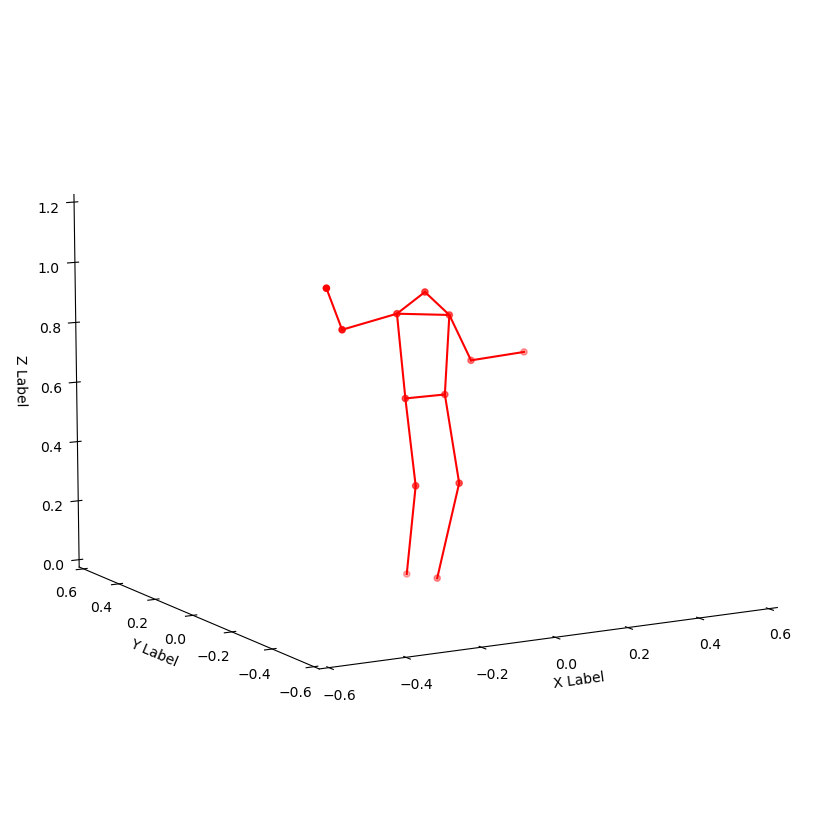

In [73]:
limits = [[-0.5, 0.5], [-0.5, 0.5], [0, 1.2]]
plot_skeleton_3d(data, angle=240, limits=limits)
plt.show()

In [21]:
mio.load(r'D:\MMD\Dataset\cameras\front_50_camera_matrix.pkl')['RT']

{'K': array([[2.01530737e+03, 0.00000000e+00, 9.60000000e+02],
        [0.00000000e+00, 2.01530737e+03, 5.40000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'RT': array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.34358856e-07, -1.00000012e+00,
          1.00000076e+01],
        [ 0.00000000e+00,  1.00000012e+00,  1.34358856e-07,
          5.00000076e+01]]),
 'P': array([[ 2.01530737e+03,  9.60000122e+02,  1.28984510e-04,
          4.80000078e+04],
        [ 0.00000000e+00,  5.40000305e+02, -2.01530750e+03,
          4.71530938e+04],
        [ 0.00000000e+00,  1.00000012e+00,  1.34358856e-07,
          5.00000076e+01]])}

In [33]:
cal = mio.load('./calibration/parameters.pkl')
rmat = cv2.Rodrigues(cal['rotation'][0])[0]
tvec = cal['transform'][0]
RT = cal['RT']
K = cal['K']
P = cal['P']
print(rmat.shape, tvec.shape, K.shape, RT.shape, P.shape)
print(P, RT)

(3, 3) (3, 1) (3, 3) (3, 4) (3, 4)
[[-4.20818148e+02 -6.11700780e+01  4.70156932e+02  1.42060708e+05]
 [ 4.45519202e+01 -5.64957870e+02  1.35590083e+02  7.88311423e+04]
 [ 2.71751068e-01 -1.63273781e-01  9.48416063e-01  2.97186110e+02]] [[-9.61727018e-01 -1.01232220e-02  2.73822321e-01  7.59478292e+01]
 [-3.51069793e-02 -9.86528861e-01 -1.59775803e-01  1.79790035e+01]
 [ 2.71751068e-01 -1.63273781e-01  9.48416063e-01  2.97186110e+02]]


In [ ]:
P

In [19]:
np.concatenate((rmat, tvec), axis=-1)

array([[-9.61727018e-01, -1.01232220e-02,  2.73822321e-01,
         7.59478292e+01],
       [-3.51069793e-02, -9.86528861e-01, -1.59775803e-01,
         1.79790035e+01],
       [ 2.71751068e-01, -1.63273781e-01,  9.48416063e-01,
         2.97186110e+02]])

In [ ]:
ptint